# Use-case for LIME explanations


## Loading the pre-trained model and its initialization

We will use the HYPERVIEW VisonTransformer model, sourced from [the huggingface repository](https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer). 

This model has won the [HYPERVIEW Challenge](https://ai4eo.eu/challenge/hyperview-challenge/) organized by The European Space Agency. It is based on the original code from the [hyperview_eagleeyes repository](https://github.com/ridvansalihkuzu/hyperview_eagleeyes/tree/master/experimental_1)

In [1]:
import os
import hashlib
import urllib
import warnings
from tqdm import tqdm
import torch

from clip_model import build_model

BASE_MODEL_URL = "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt"


def download(url: str, root: str, error_checksum: bool = True) -> str:
    os.makedirs(root, exist_ok=True)
    filename = os.path.basename(url)

    expected_sha256 = url.split("/")[-2]
    download_target = os.path.join(root, filename)
    print("INFO: Download Target: {}".format(download_target))

    if os.path.exists(download_target) and not os.path.isfile(download_target):
        raise RuntimeError(f"{download_target} exists and is not a regular file")

    if os.path.isfile(download_target):
        if hashlib.sha256(open(download_target, "rb").read()).hexdigest() == expected_sha256:
            return download_target
        else:
            warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")

    with urllib.request.urlopen(url) as source, open(download_target, "wb") as output:
        with tqdm(
            total=int(source.info().get("Content-Length")), ncols=80, unit="iB", unit_scale=True, unit_divisor=1024
        ) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))

    if hashlib.sha256(open(download_target, "rb").read()).hexdigest() != expected_sha256:
        if error_checksum:
            raise RuntimeError("Model has been downloaded but the SHA256 checksum does not not match")
        else:
            warnings.warn("Model has been downloaded but the SHA256 checksum does not not match")

    return download_target


def load_base_clip(download_root: str, class_num: int = 1000):
    model_path = download(BASE_MODEL_URL, download_root)
    model = torch.jit.load(model_path, map_location="cpu").eval()
    model = build_model(model.state_dict(), downstream_task=4, class_num=class_num)
    model.float()
    return model

In [2]:
import torch 
import numpy as np
from torchvision import transforms

from matplotlib import pyplot as plt

In [3]:
vit_url = "https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer/resolve/main/VisionTransformer.pt"

download_root = os.path.expanduser("~/.cache/clip") # Change this to the directory where you want to download the model
device = "cpu"  # Change to 'cuda' if you have a GPU
num_classes = 4  # Number of classes in the original HYPERVIEW dataset

# Load the CLIP model with the downstream task configuration
model = load_base_clip(download_root=download_root, class_num=num_classes)

# Load the pre-trained weights
vit_checkpoint_path = download(vit_url, download_root, error_checksum=False) 
model.load_state_dict(torch.load(vit_checkpoint_path, map_location=device))
model.eval()
print("Model loaded successfully")

INFO: Download Target: /Users/vladimirzaigrajew/.cache/clip/ViT-L-14.pt
INFO: Download Target: /Users/vladimirzaigrajew/.cache/clip/VisionTransformer.pt


/var/folders/33/rj1th5sj2zg3nk1g8kp_7mfh0000gn/T/ipykernel_48643/2688802795.py:28: UserWarning: /Users/vladimirzaigrajew/.cache/clip/VisionTransformer.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
100%|█████████████████████████████████████| 1.60G/1.60G [01:39<00:00, 17.3MiB/s]
/var/folders/33/rj1th5sj2zg3nk1g8kp_7mfh0000gn/T/ipykernel_48643/2688802795.py:46: UserWarning: Model has been downloaded but the SHA256 checksum does not not match
  warnings.warn("Model has been downloaded but the SHA256 checksum does not not match")


Model loaded successfully


## Load the sample images

In [4]:
def _shape_pad(data):
    max_edge = np.max(data.shape[1:])
    shape = (max_edge, max_edge)
    padded = np.pad(data, ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))), "wrap")
    return padded


def load_single_npz_image(image_path):
    with np.load(image_path) as npz:
        data = npz["data"]
        mask = npz["mask"]

        mask = 1 - mask.astype(int)

        mask = _shape_pad(mask)
        data = _shape_pad(data)

        mask = mask.transpose((1, 2, 0))
        data = data.transpose((1, 2, 0))
        data = data / 5419

        return data, mask

def get_eval_transform(image_shape):
    return transforms.Compose(
        [
            
            transforms.Resize((image_shape, image_shape)),
            # transforms.Normalize(mean=eval_stats[0]*eval_stats[2], std=eval_stats[1]*eval_stats[2], max_pixel_value=1)
            # transforms.ToTensor(),
        ]
    )

In [5]:
data, mask = load_single_npz_image("sample_data/2.npz")
data = data * mask
data = torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch = eval_tr(data)

In [6]:
wavelengths = [
    462.08,
    465.27,
    468.47,
    471.67,
    474.86,
    478.06,
    481.26,
    484.45,
    487.65,
    490.85,
    494.04,
    497.24,
    500.43,
    503.63,
    506.83,
    510.03,
    513.22,
    516.42,
    519.61,
    522.81,
    526.01,
    529.2,
    532.4,
    535.6,
    538.79,
    541.99,
    545.19,
    548.38,
    551.58,
    554.78,
    557.97,
    561.17,
    564.37,
    567.56,
    570.76,
    573.96,
    577.15,
    580.35,
    583.55,
    586.74,
    589.94,
    593.14,
    596.33,
    599.53,
    602.73,
    605.92,
    609.12,
    612.32,
    615.51,
    618.71,
    621.91,
    625.1,
    628.3,
    631.5,
    634.69,
    637.89,
    641.09,
    644.28,
    647.48,
    650.67,
    653.87,
    657.07,
    660.27,
    663.46,
    666.66,
    669.85,
    673.05,
    676.25,
    679.45,
    682.64,
    685.84,
    689.03,
    692.23,
    695.43,
    698.62,
    701.82,
    705.02,
    708.21,
    711.41,
    714.61,
    717.8,
    721.0,
    724.2,
    727.39,
    730.59,
    733.79,
    736.98,
    740.18,
    743.38,
    746.57,
    749.77,
    752.97,
    756.16,
    759.36,
    762.56,
    765.75,
    768.95,
    772.15,
    775.34,
    778.54,
    781.74,
    784.93,
    788.13,
    791.33,
    794.52,
    797.72,
    800.92,
    804.11,
    807.31,
    810.51,
    813.7,
    816.9,
    820.1,
    823.29,
    826.49,
    829.68,
    832.88,
    836.08,
    839.28,
    842.47,
    845.67,
    848.86,
    852.06,
    855.26,
    858.46,
    861.65,
    864.85,
    868.04,
    871.24,
    874.44,
    877.63,
    880.83,
    884.03,
    887.22,
    890.42,
    893.62,
    896.81,
    900.01,
    903.21,
    906.4,
    909.6,
    912.8,
    915.99,
    919.19,
    922.39,
    925.58,
    928.78,
    931.98,
    935.17,
    938.37,
]

## Load the package and preview the images

In [7]:
image_torch.shape

torch.Size([150, 224, 224])

(tensor(False),
 torch.Size([150, 224, 224]),
 <matplotlib.image.AxesImage at 0x130742c40>)

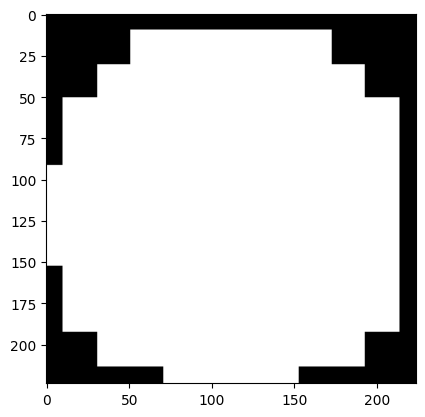

In [8]:
binary_mask = image_torch != 0
torch.all(binary_mask), binary_mask.shape, plt.imshow(binary_mask[0].numpy(), cmap="gray")

In [9]:
import meteors as mt

image_0 = mt.HSI(image=image_torch, wavelengths=wavelengths, orientation="CHW", binary_mask=binary_mask)

2024-09-12 11:23:51.261 | DEBUG    | meteors.hsi:resolve_inference_device:112 - Device for inference: cpu


<Axes: >

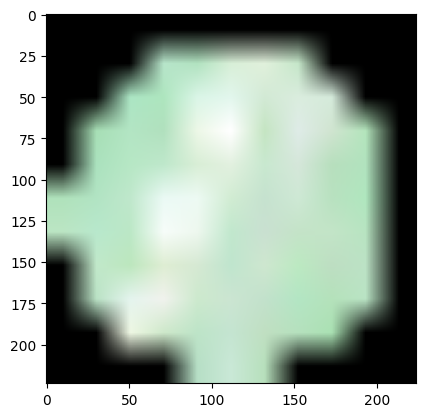

In [10]:
mt.visualize.lime_visualize.visualize_hsi(image_0, None)

In [11]:
image_0.image.shape

torch.Size([150, 224, 224])

In [12]:
model(image_0.image.unsqueeze(0), device)  # example model predictions

tensor([[0.2073, 0.3471, 0.3853, 0.8820]], grad_fn=<HardsigmoidBackward0>)

## Initialize the LIME object

In [13]:
explainable_model = mt.utils.models.ExplainableModel(model, "regression")

interpretable_model = mt.utils.models.SkLearnLasso(alpha=0.00001)

lime = mt.Lime(explainable_model, interpretable_model)

Text(0.5, 0.98, 'Patch segmentation and the image')

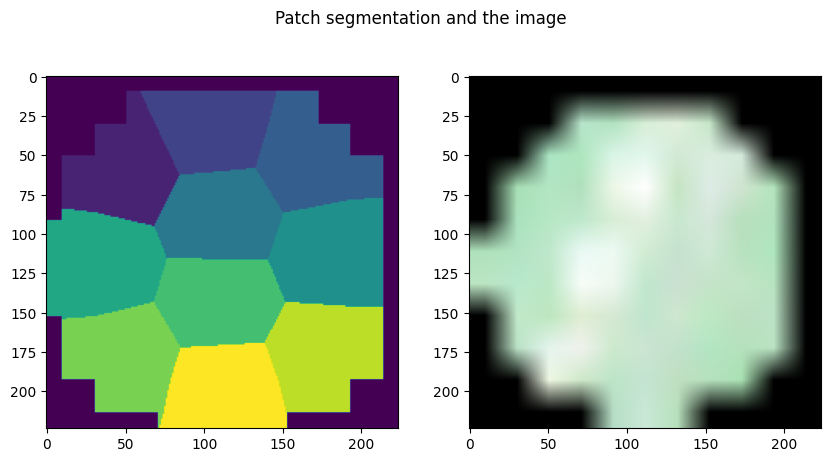

In [14]:
segmentation_mask = lime.get_segmentation_mask(image_0)  # produce a slic segmentation mask


fig = plt.figure(figsize=(10, 5))
# subplots
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(segmentation_mask[0, ...])

ax2.imshow(image_0.get_rgb_image(apply_mask=False, output_channel_axis=2))

plt.suptitle("Patch segmentation and the image")

In [15]:
spatial_attributes = lime.get_spatial_attributes(image_0, segmentation_mask, target=1)

2024-09-12 11:24:10.009 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


(<Figure size 1500x500 with 4 Axes>,
 array([<Axes: title={'center': 'Original image'}>,
        <Axes: title={'center': 'Attribution Map'}>,
        <Axes: title={'center': 'Mask'}>], dtype=object))

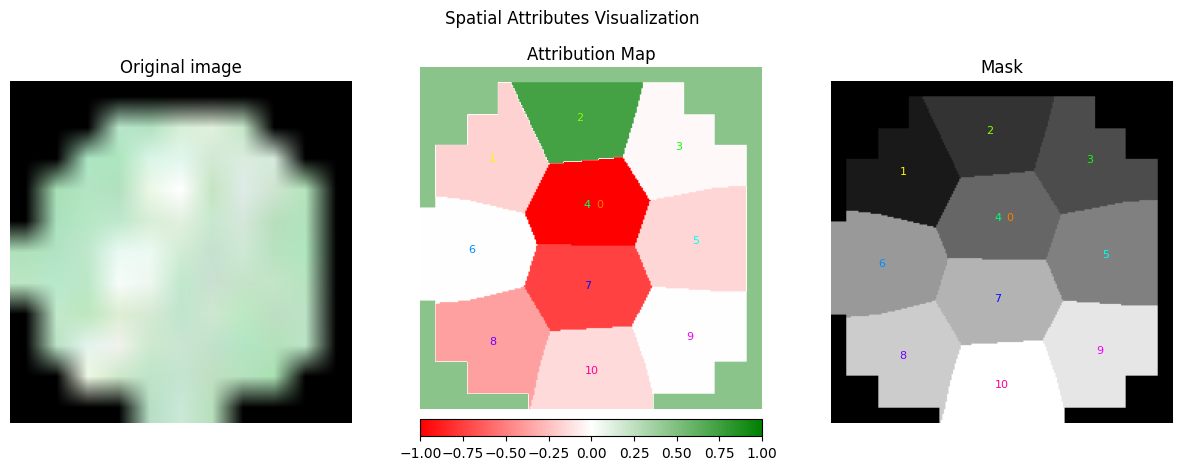

In [16]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)

In [17]:
band_mask, band_names = mt.Lime.get_band_mask(image_0, ["R", "G", "B"])

2024-09-12 11:24:11.034 | DEBUG    | meteors.lime:get_band_mask:956 - Getting band mask from band names of spectral bands
2024-09-12 11:24:11.039 | DEBUG    | meteors.lime:_get_band_wavelengths_indices_from_band_names:1101 - band_names is a list of segments, creating a dictionary of segments
2024-09-12 11:24:11.045 | DEBUG    | meteors.lime:_create_tensor_band_mask:1428 - Creating a band mask on the device cpu using 3 segments
2024-09-12 11:24:11.058 | WARNING  | meteors.lime:_check_overlapping_segments:1277 - Segments G and B are overlapping on wavelength 510.0299987792969
2024-09-12 11:24:11.062 | WARNING  | meteors.lime:_check_overlapping_segments:1277 - Segments G and B are overlapping on wavelength 513.219970703125
2024-09-12 11:24:11.064 | WARNING  | meteors.lime:_check_overlapping_segments:1277 - Segments G and B are overlapping on wavelength 516.4199829101562
2024-09-12 11:24:11.068 | WARNING  | meteors.lime:_check_overlapping_segments:1277 - Segments G and B are overlapping on

In [18]:
band_mask.shape

torch.Size([150, 1, 1])

In [19]:
band_names

{'R': 1, 'G': 2, 'B': 3}

In [20]:
spectral_attributes = lime.get_spectral_attributes(image_0, band_mask=band_mask, target=1, band_names=band_names)

2024-09-12 11:24:11.161 | DEBUG    | meteors.lime:get_spectral_attributes:1666 - Band names are provided, using them. In future it there should be an option to validate them
2024-09-12 11:24:35.427 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


<Axes: title={'center': 'Attributions by Magnitude'}, xlabel='Group', ylabel='Average Attribution Magnitude'>

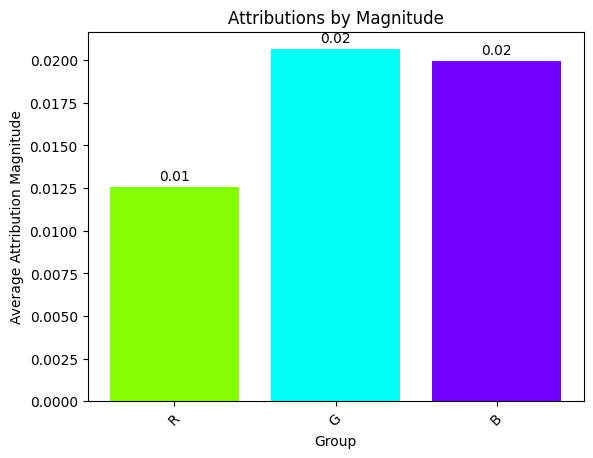

In [21]:
mt.visualize.visualize_spectral_attributes_by_magnitude(spectral_attributes, None)

<Axes: title={'center': 'Attributions by Waveband'}, xlabel='Wavelength (nm)', ylabel='Correlation with Output'>

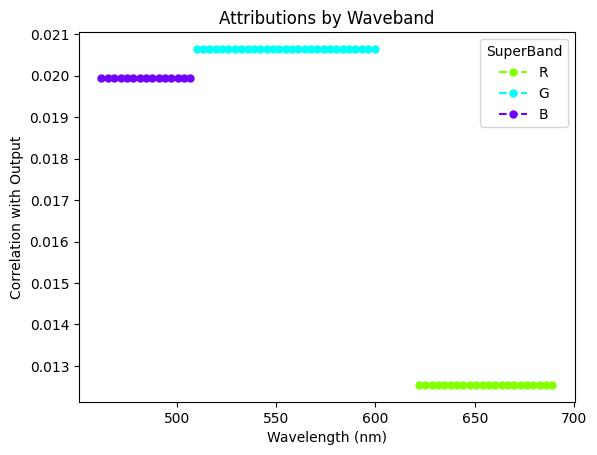

In [22]:
mt.visualize.visualize_spectral_attributes_by_waveband(spectral_attributes, None)

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Attributions by Waveband'}, xlabel='Wavelength (nm)', ylabel='Correlation with Output'>,
        <Axes: title={'center': 'Attributions by Magnitude'}, xlabel='Group', ylabel='Average Attribution Magnitude'>],
       dtype=object))

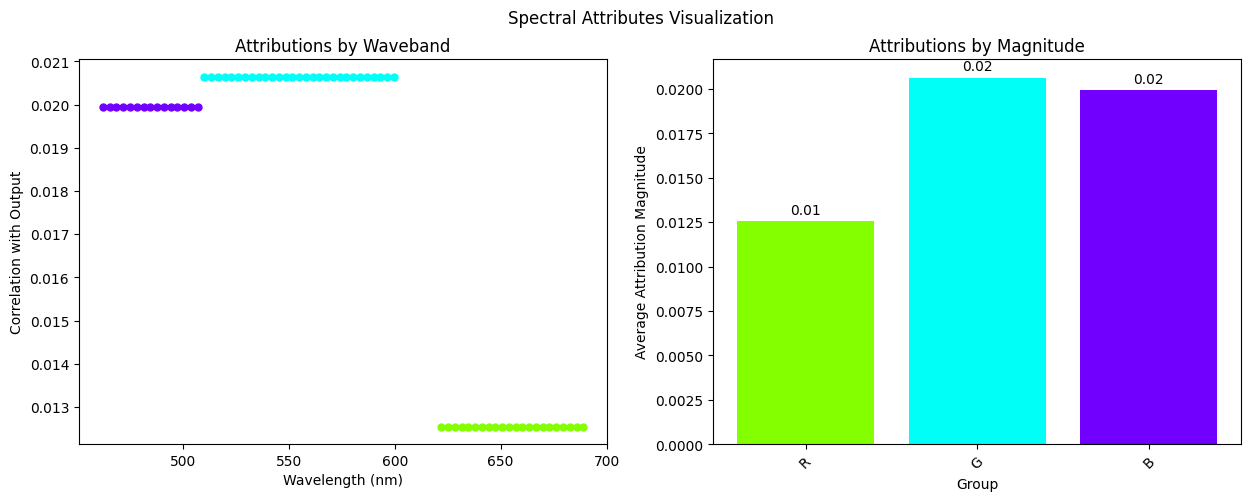

In [23]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, None)

2024-09-12 11:24:45.852 | DEBUG    | meteors.hsi:resolve_inference_device:112 - Device for inference: cpu


<Axes: >

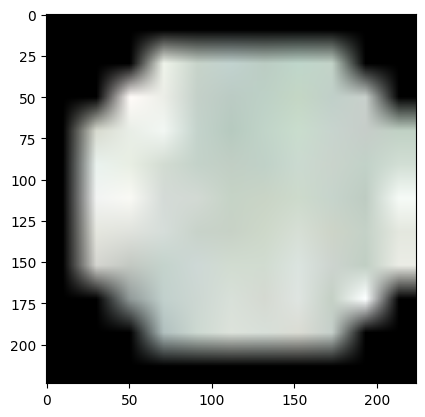

In [24]:
data, mask = load_single_npz_image("sample_data/1.npz")
data = data * mask
data = torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch = eval_tr(data)
binary_mask = image_torch != 0

image_1 = mt.HSI(image=image_torch, wavelengths=wavelengths, orientation="CHW", binary_mask=binary_mask)

mt.visualize.lime_visualize.visualize_hsi(image_1, None)

Text(0.5, 0.98, 'Patch segmentation and the image')

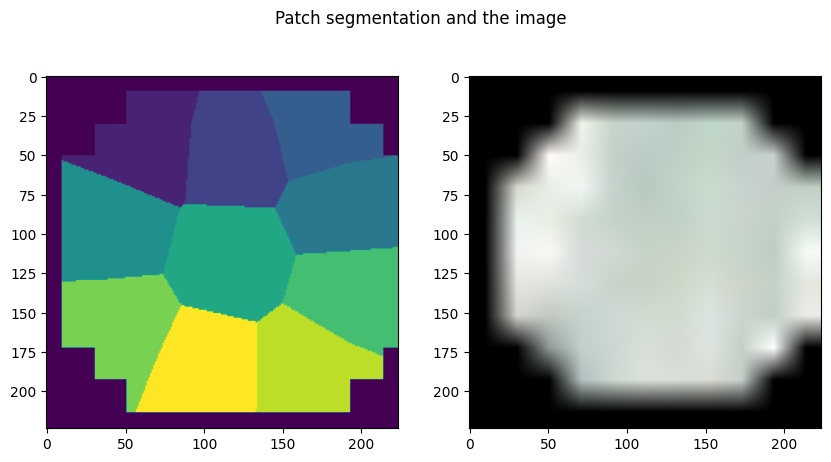

In [25]:
segmentation_mask_image_1 = lime.get_segmentation_mask(image_1)  # produce a slic segmentation mask


fig = plt.figure(figsize=(10, 5))
# subplots
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(segmentation_mask_image_1[0, ...])

ax2.imshow(image_1.get_rgb_image(apply_mask=False, output_channel_axis=2))

plt.suptitle("Patch segmentation and the image")

In [26]:
spatial_attributes_1 = lime.get_spatial_attributes(image_1, segmentation_mask, target=1)

2024-09-12 11:25:15.395 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


(<Figure size 1500x500 with 4 Axes>,
 array([<Axes: title={'center': 'Original image'}>,
        <Axes: title={'center': 'Attribution Map'}>,
        <Axes: title={'center': 'Mask'}>], dtype=object))

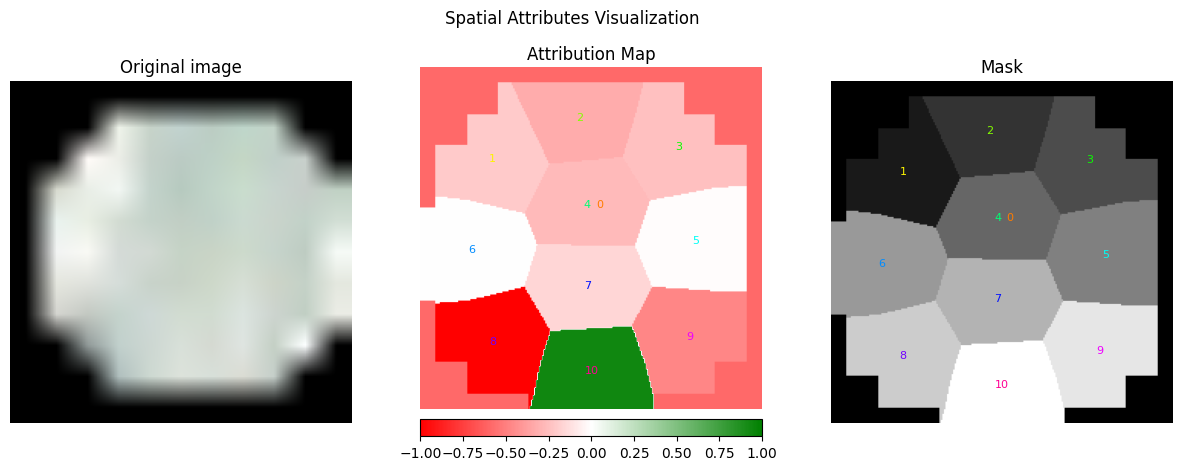

In [27]:
mt.visualize.visualize_spatial_attributes(spatial_attributes_1)

In [28]:
spectral_attributes_1 = lime.get_spectral_attributes(image_1, band_mask=band_mask, target=1, band_names=band_names)

2024-09-12 11:25:16.447 | DEBUG    | meteors.lime:get_spectral_attributes:1666 - Band names are provided, using them. In future it there should be an option to validate them
2024-09-12 11:25:28.409 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


<Axes: title={'center': 'Attributions by Magnitude'}, xlabel='Group', ylabel='Average Attribution Magnitude'>

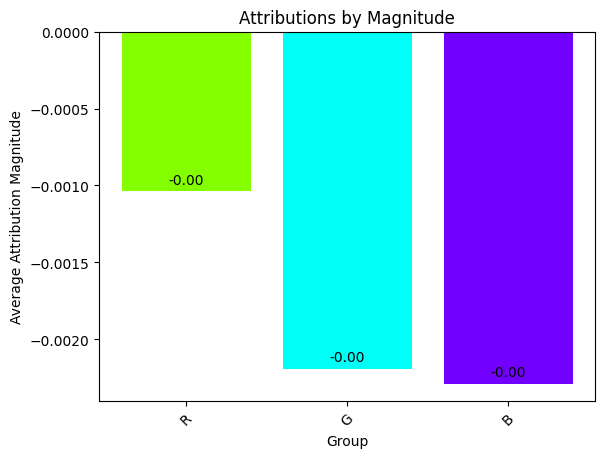

In [29]:
mt.visualize.visualize_spectral_attributes_by_magnitude(spectral_attributes_1, None)

<Axes: title={'center': 'Attributions by Waveband'}, xlabel='Wavelength (nm)', ylabel='Correlation with Output'>

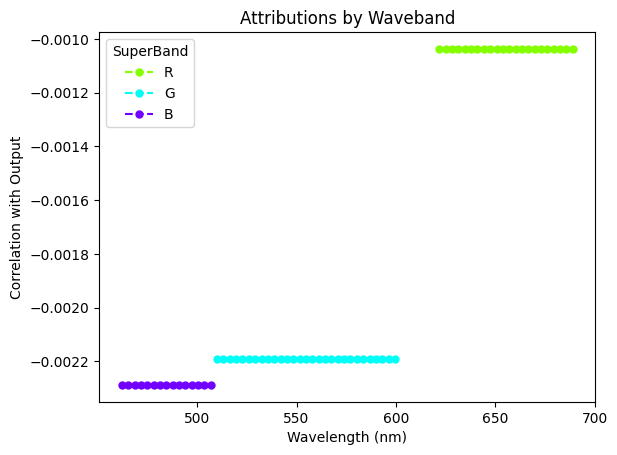

In [30]:
mt.visualize.visualize_spectral_attributes_by_waveband(spectral_attributes_1, None)

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Attributions by Waveband'}, xlabel='Wavelength (nm)', ylabel='Correlation with Output'>,
        <Axes: title={'center': 'Attributions by Magnitude'}, xlabel='Group', ylabel='Average Attribution Magnitude'>],
       dtype=object))

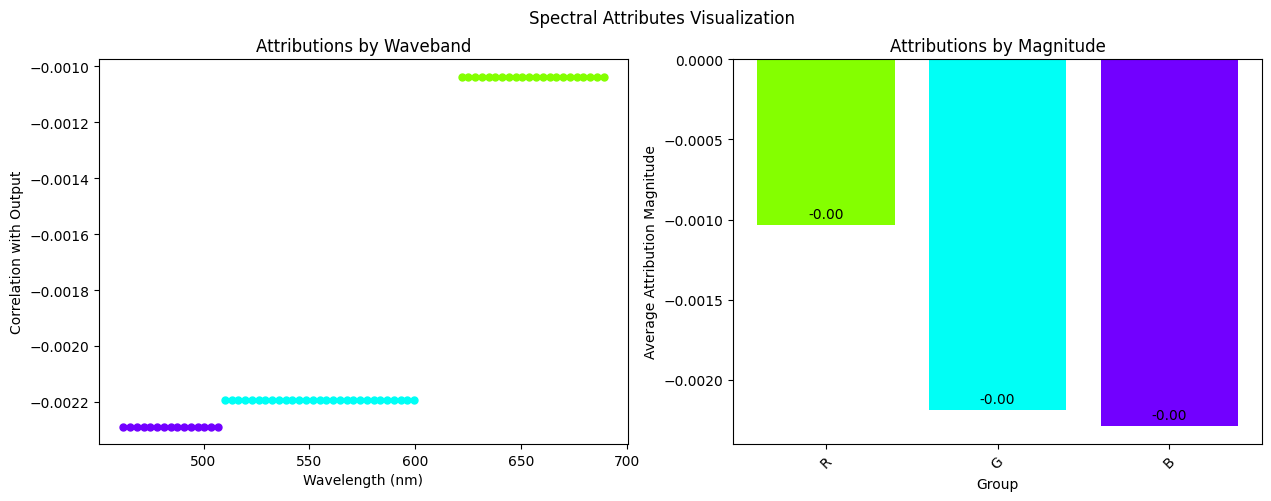

In [31]:
mt.visualize.visualize_spectral_attributes(spectral_attributes_1, None)

<Axes: title={'center': 'Attributions by Magnitude'}, xlabel='Group', ylabel='Average Attribution Magnitude'>

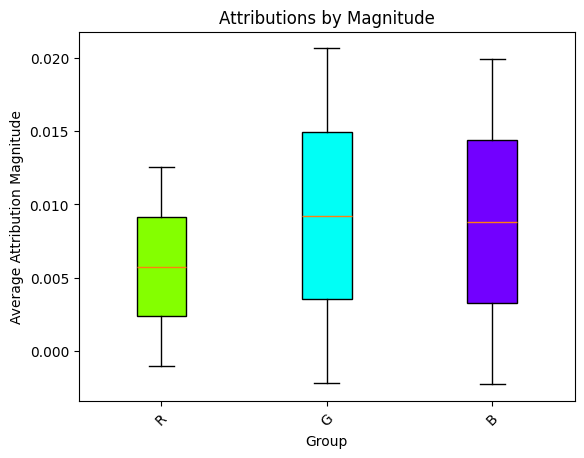

In [32]:
mt.visualize.visualize_spectral_attributes_by_magnitude([spectral_attributes, spectral_attributes_1], None)

<Axes: title={'center': 'Attributions by Waveband'}, xlabel='Wavelength (nm)', ylabel='Correlation with Output'>

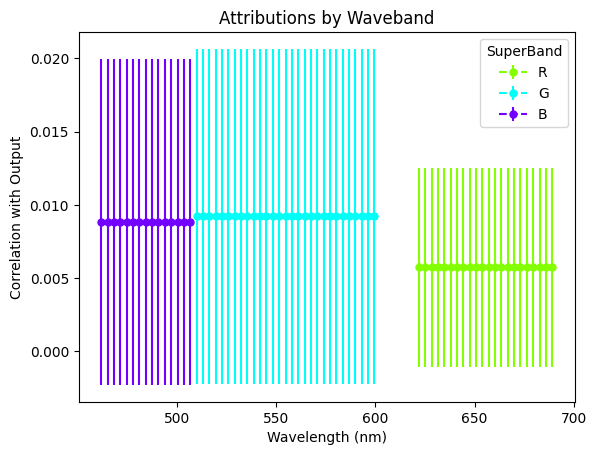

In [33]:
mt.visualize.visualize_spectral_attributes_by_waveband([spectral_attributes, spectral_attributes_1], None)

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Attributions by Waveband'}, xlabel='Wavelength (nm)', ylabel='Correlation with Output'>,
        <Axes: title={'center': 'Attributions by Magnitude'}, xlabel='Group', ylabel='Average Attribution Magnitude'>],
       dtype=object))

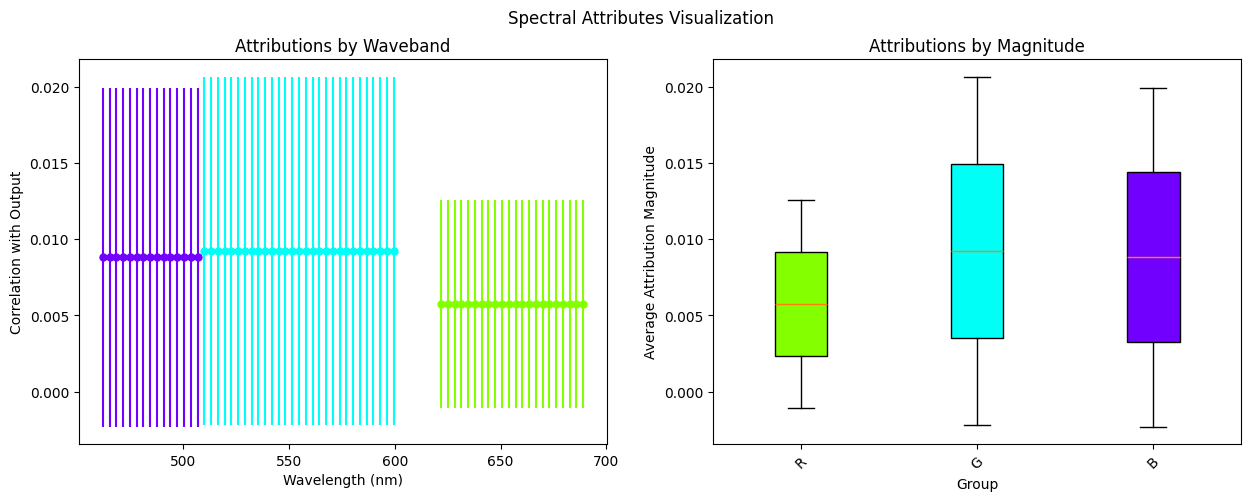

In [34]:
mt.visualize.visualize_spectral_attributes([spectral_attributes, spectral_attributes_1], None)